In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
import seaborn as sns
from evaluation import *
from GRM import *


def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-24 09:44:48.604375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 09:44:48.797217: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 09:44:48.849279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 09:44:51.926430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #2
Using GPU #2


## Loading Dataset PBMC

In [2]:
file_path = os.path.join(data_folder_path, 'PBMC10k', 'pbmc10k.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
atac = mdata.mod['atac']

col_dict1 = {'CD4+ naïve T': '#8000ff',
                 'CD8+ activated T': '#5641fd',
                 'naïve B': '#2c7ef7',
                 'intermediate mono': '#00b5eb',
                 'MAIT': '#2adddd',
                 'mDC': '#54f6cb',
                 'CD14 mono': '#80ffb4',
                 'memory B': '#abf69b',
                 'CD8+ naïve T': '#d4dd80',
                 'pDC': '#ffb360',
                 'CD16 mono': '#ff7e41',
                 'CD4+ memory T': '#ff4121',
                 'NK': '#ff0000',
                 None: '#CDC9C9'}

In [3]:
rna

AnnData object with n_obs × n_vars = 9393 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
atac

AnnData object with n_obs × n_vars = 9393 × 5000
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'lsi', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

atac_Normalized_2000 = (atac.X-np.mean(atac.X,0))/np.std(atac.X,0)

## Gene Relevance Map
#### We will load the cell and gene embedding of the best result, associated with the 2D embedded MOGP with 500 epochs. Then, we load their meta-cells and meta-genes.
#### Its gene relevance map and meta gene relevance map are provided in subsequent steps. 

In [6]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001

In [7]:
title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux'+title+'/embs1.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

In [8]:
title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux'+title+'/embs2.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()


Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

In [9]:
n_SEACells_cells=120
title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux'+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'rb')
metaCells = pickle.load(file)
file.close()
RNA_struct_MOGP.obs[['SEACell']]=metaCells

n_SEACells_genes=100
title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux'+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'rb')
metaGenes = pickle.load(file)
file.close()
Genes_struct_MOGP.obs[['SEACell']]=metaGenes

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

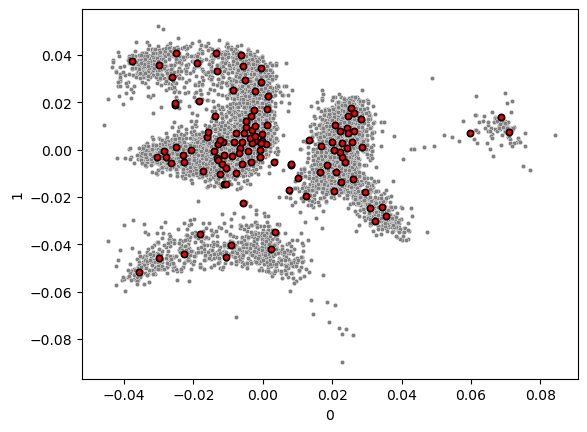

In [10]:
import seaborn as sns
umap = pd.DataFrame(RNA_struct_MOGP.obsm['X_umap']).set_index(RNA_struct_MOGP.obs_names).join(RNA_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_cells = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

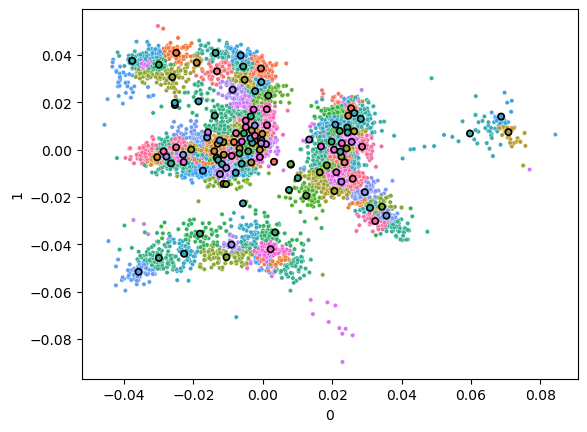

In [11]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

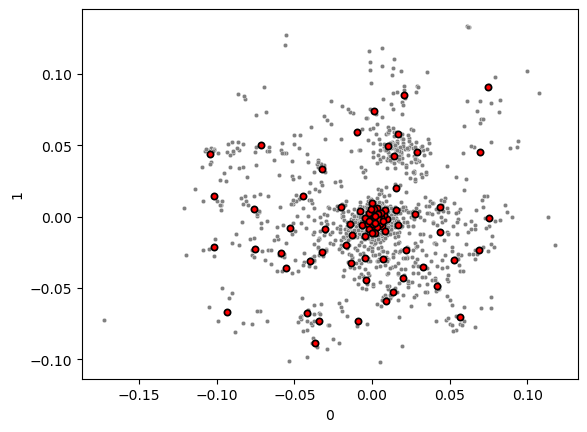

In [12]:
import seaborn as sns
umap = pd.DataFrame(Genes_struct_MOGP.obsm['X_umap']).set_index(Genes_struct_MOGP.obs_names).join(Genes_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_genes = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

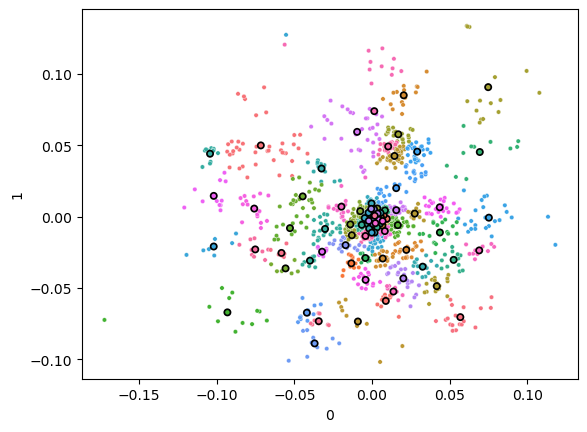

In [13]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

In [14]:
RNA_struct_MOGP

AnnData object with n_obs × n_vars = 9393 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

In [15]:
Genes_struct_MOGP

AnnData object with n_obs × n_vars = 2000 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

#### The functions related to Gene Relevance MAP are defined based on the following paper: 
"Angerer, P., Fischer, D.S., Theis, F.J., Scialdone, A. and Marr, C., 2020. Automatic identification of relevant genes from low-dimensional embeddings of single-cell RNA-seq data. Bioinformatics, 36(15), pp.4291-4295."

In [16]:
n_neighbors=6
#The value of the rg_max parameter significantly impacts the results and requires careful tuning to achieve optimal performance.
rg_max=100
n_bins=100

In [18]:
rank_dhatgc = rank_dhatgc_score(RNA_struct_MOGP, Genes_struct_MOGP, RNA_Normalized_2000, n_neighbors)

In [15]:
#Since providing the values of rank_dhatgc is time-consuming, we will save it for subsequent trials.
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux '+title+'/rank_dhatgc_GeneRelevance3.csv' 
file = open(save_path,'wb')
pickle.dump(rank_dhatgc,file)
file.close()

In [15]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC10K-RNA-GPFlux '+title+'/rank_dhatgc_GeneRelevance3.csv' 
file = open(save_path,'rb')
rank_dhatgc = pickle.load(file)
file.close()

#### Gene Relevance for some famous genes: this is done for testing the results

In [16]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc, rg_max)

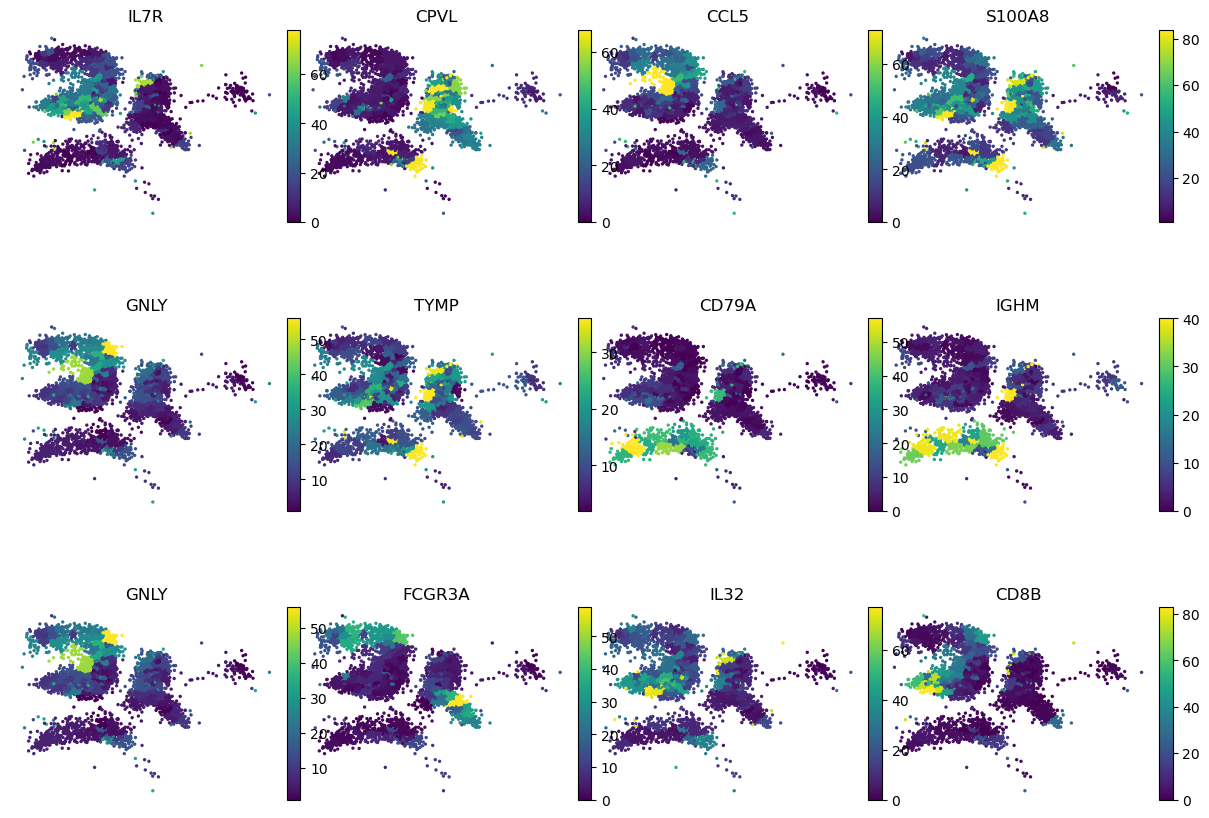

In [17]:
gene_list=["IL7R", "CPVL", "CCL5", "S100A8", "GNLY", "TYMP", "CD79A", "IGHM", "GNLY", "FCGR3A","IL32","CD8B"]
Gene_Relevance_Map(rna, gene_list, LR_gPsi, avg_Psi)

#### Global Meta Gene Relevance: Instead of computing gene relevance, we compute the relevance of meta-genes to the cell embedding space. We then sort these meta-genes to compute the Global Meta Gene Relevance Map. For further information, please refer to the paper mentioned above.

In [18]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [19]:
LR_gPsi, avg_Psi, Global_idx = LRgPsi_avgPsi_GlobalMetascore(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatMetagc, rg_max)

In [20]:
mcs_genes_sorted0=mcs_genes[0].values[Global_idx]
mcs_genes_sorted1=mcs_genes[1].values[Global_idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[Global_idx]

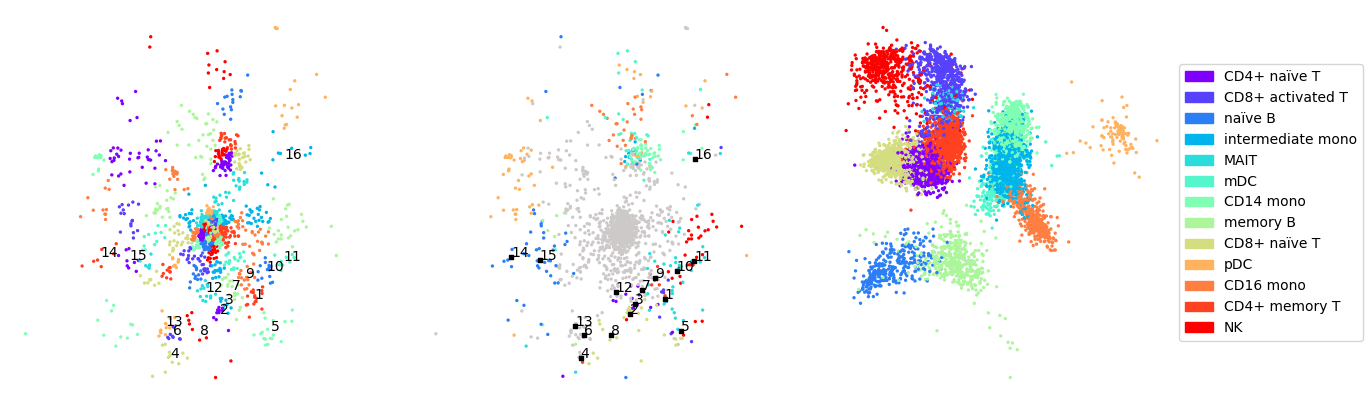

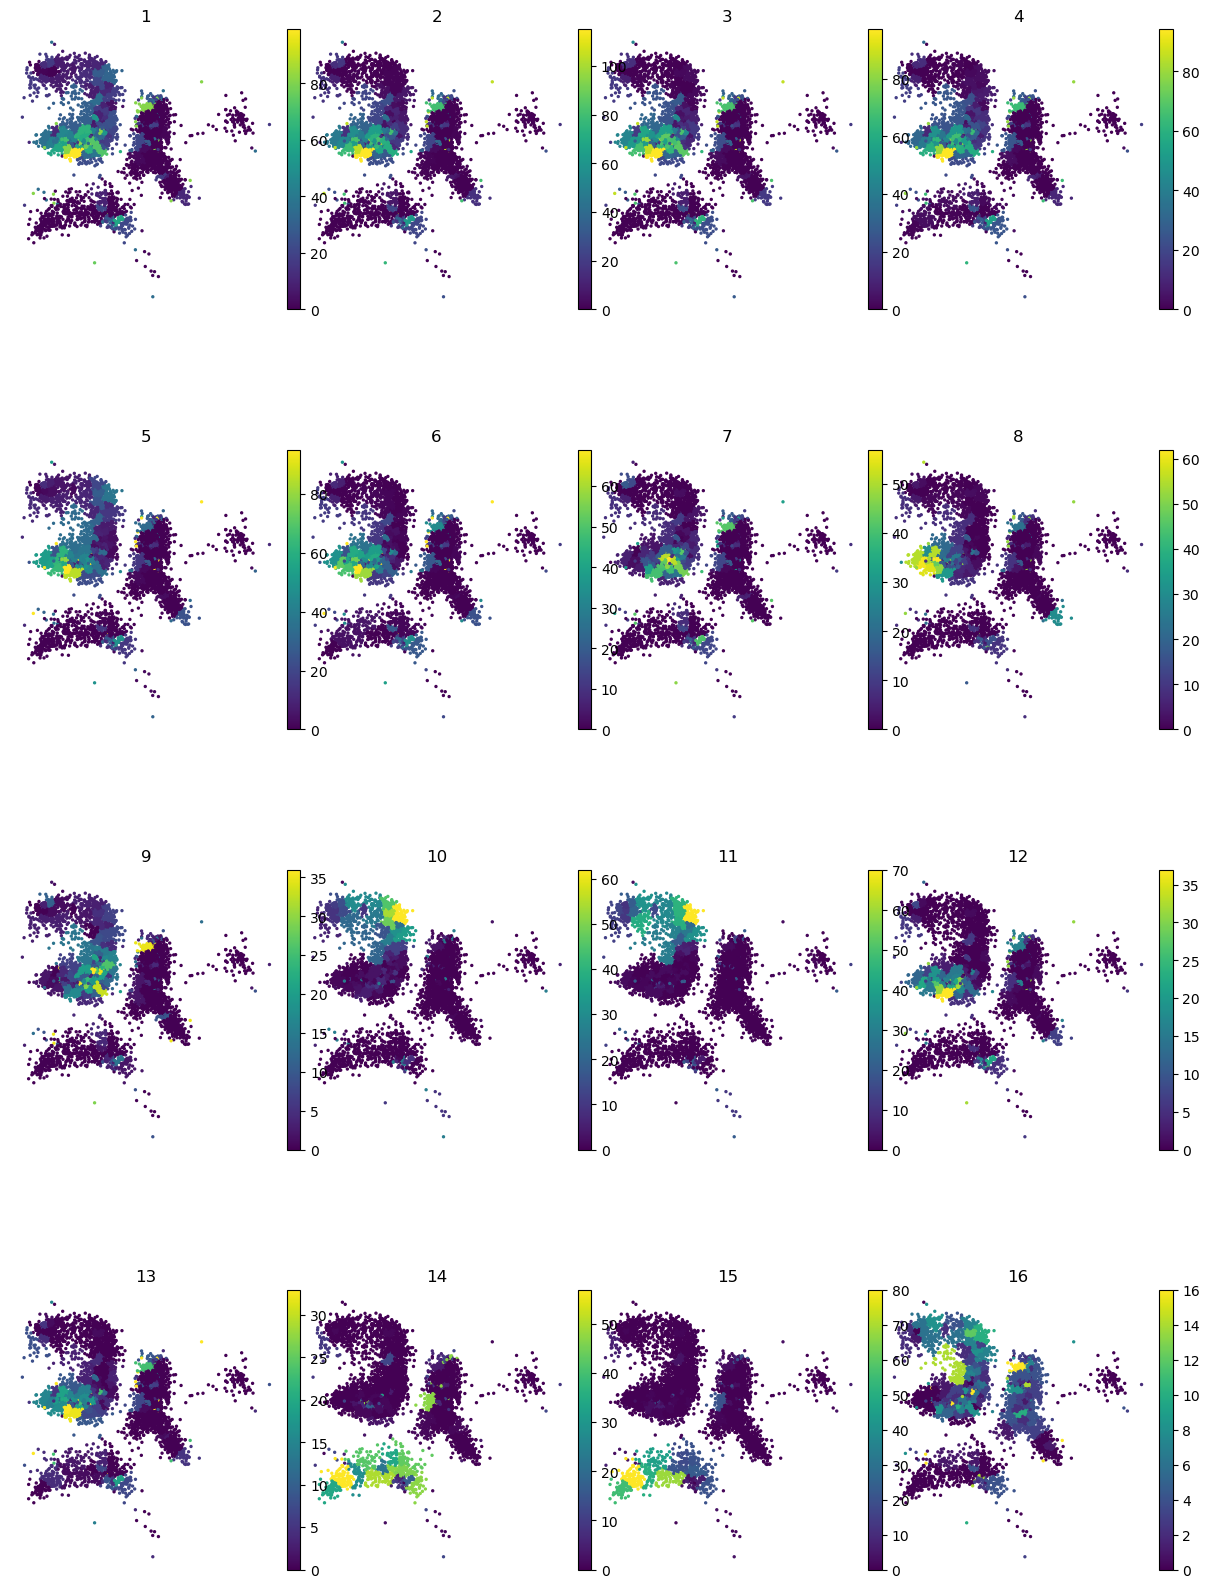

In [21]:
Global_Gene_Relevance_Map_PBMC10k(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=0)

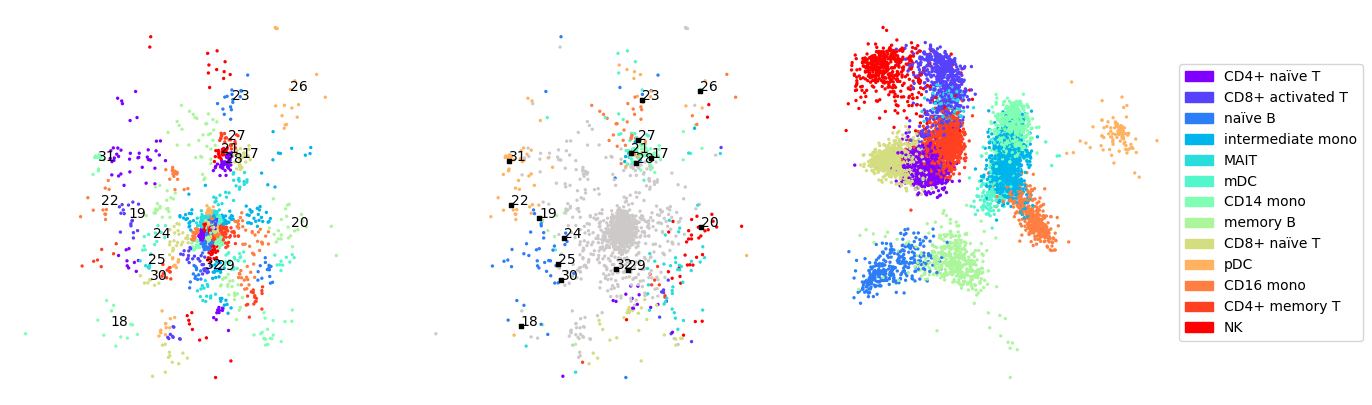

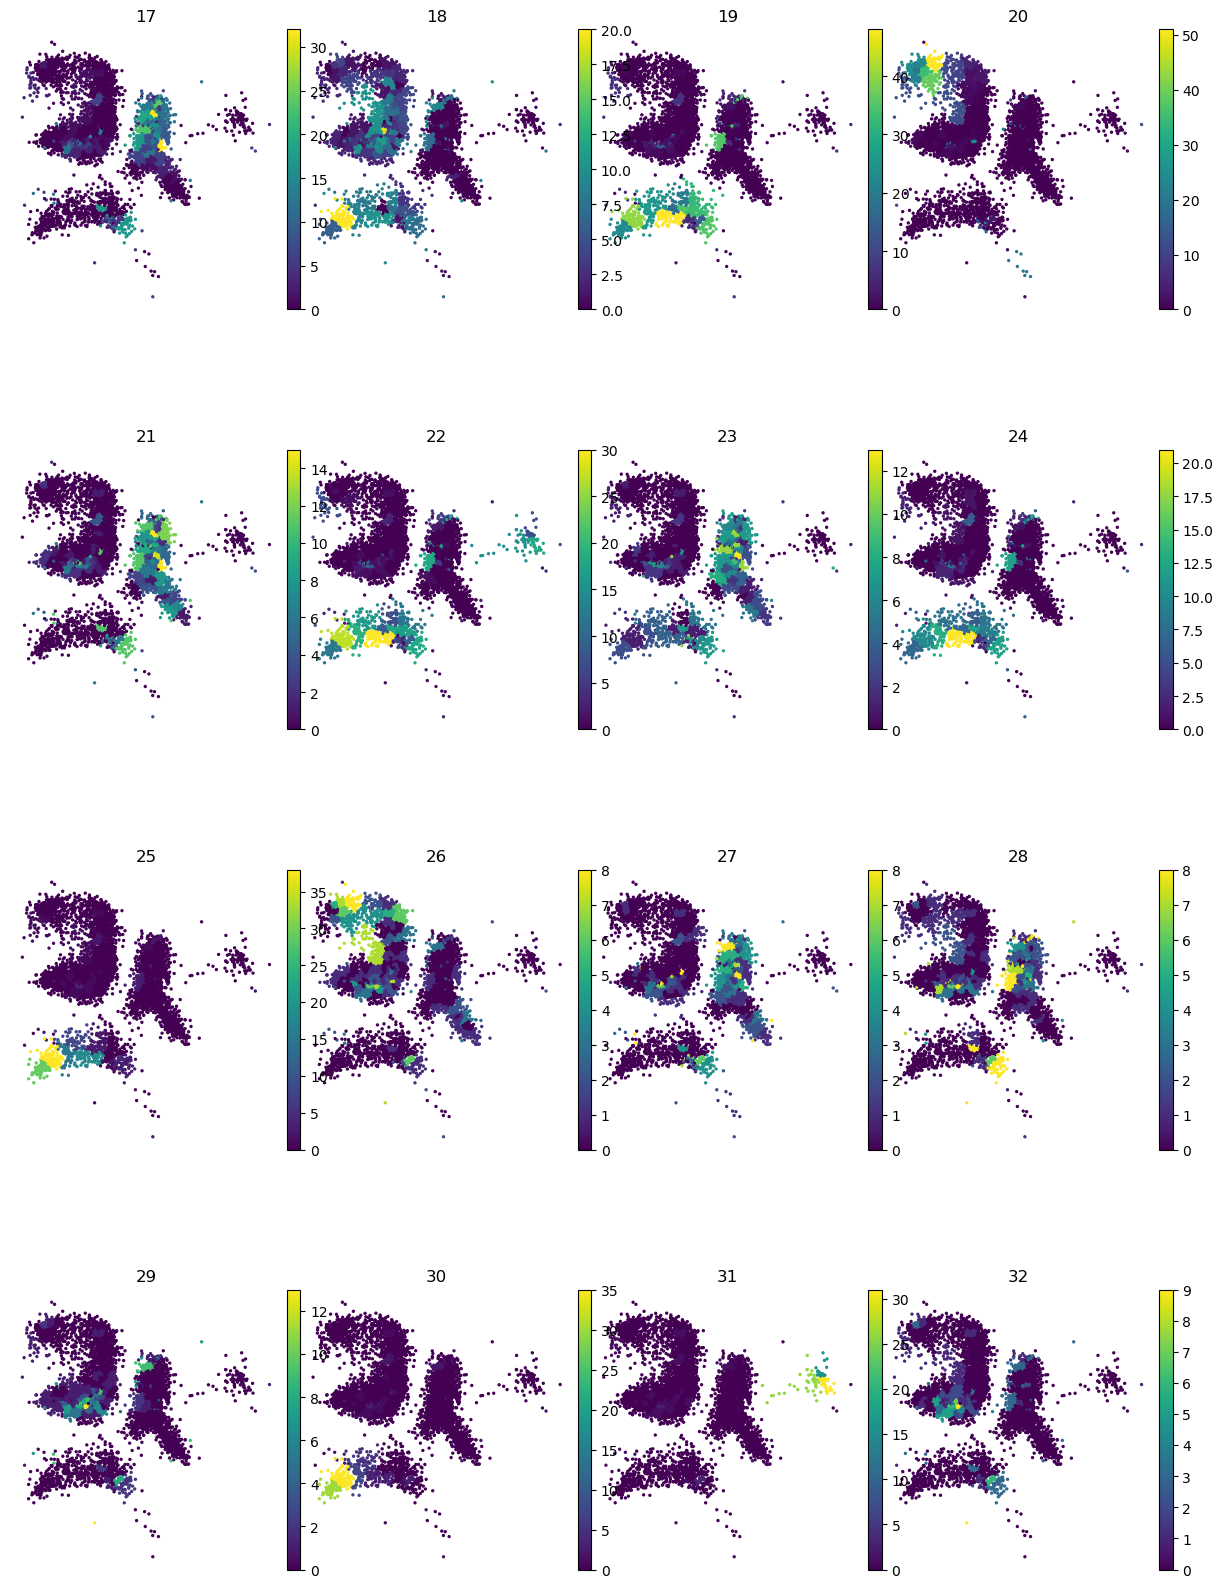

In [22]:
Global_Gene_Relevance_Map_PBMC10k(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=16)

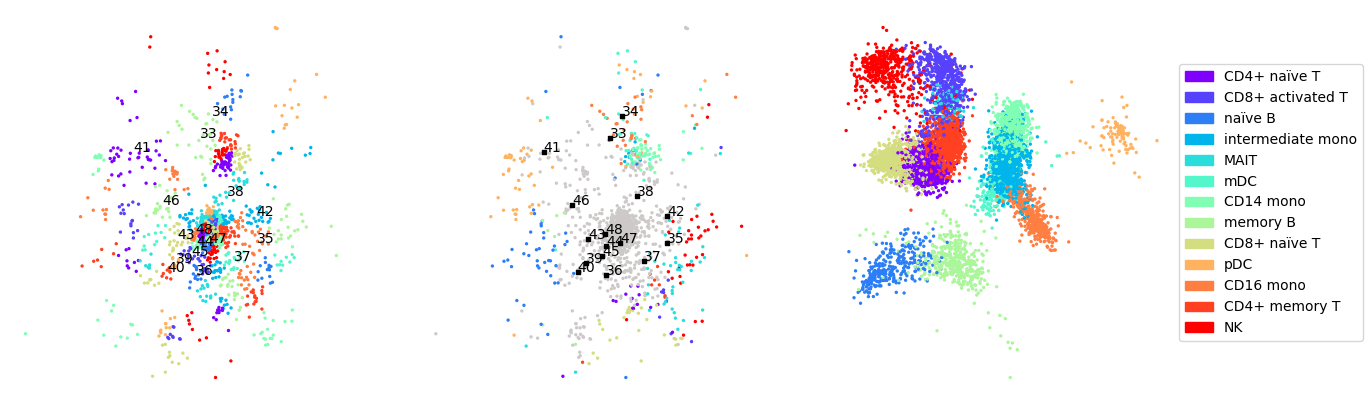

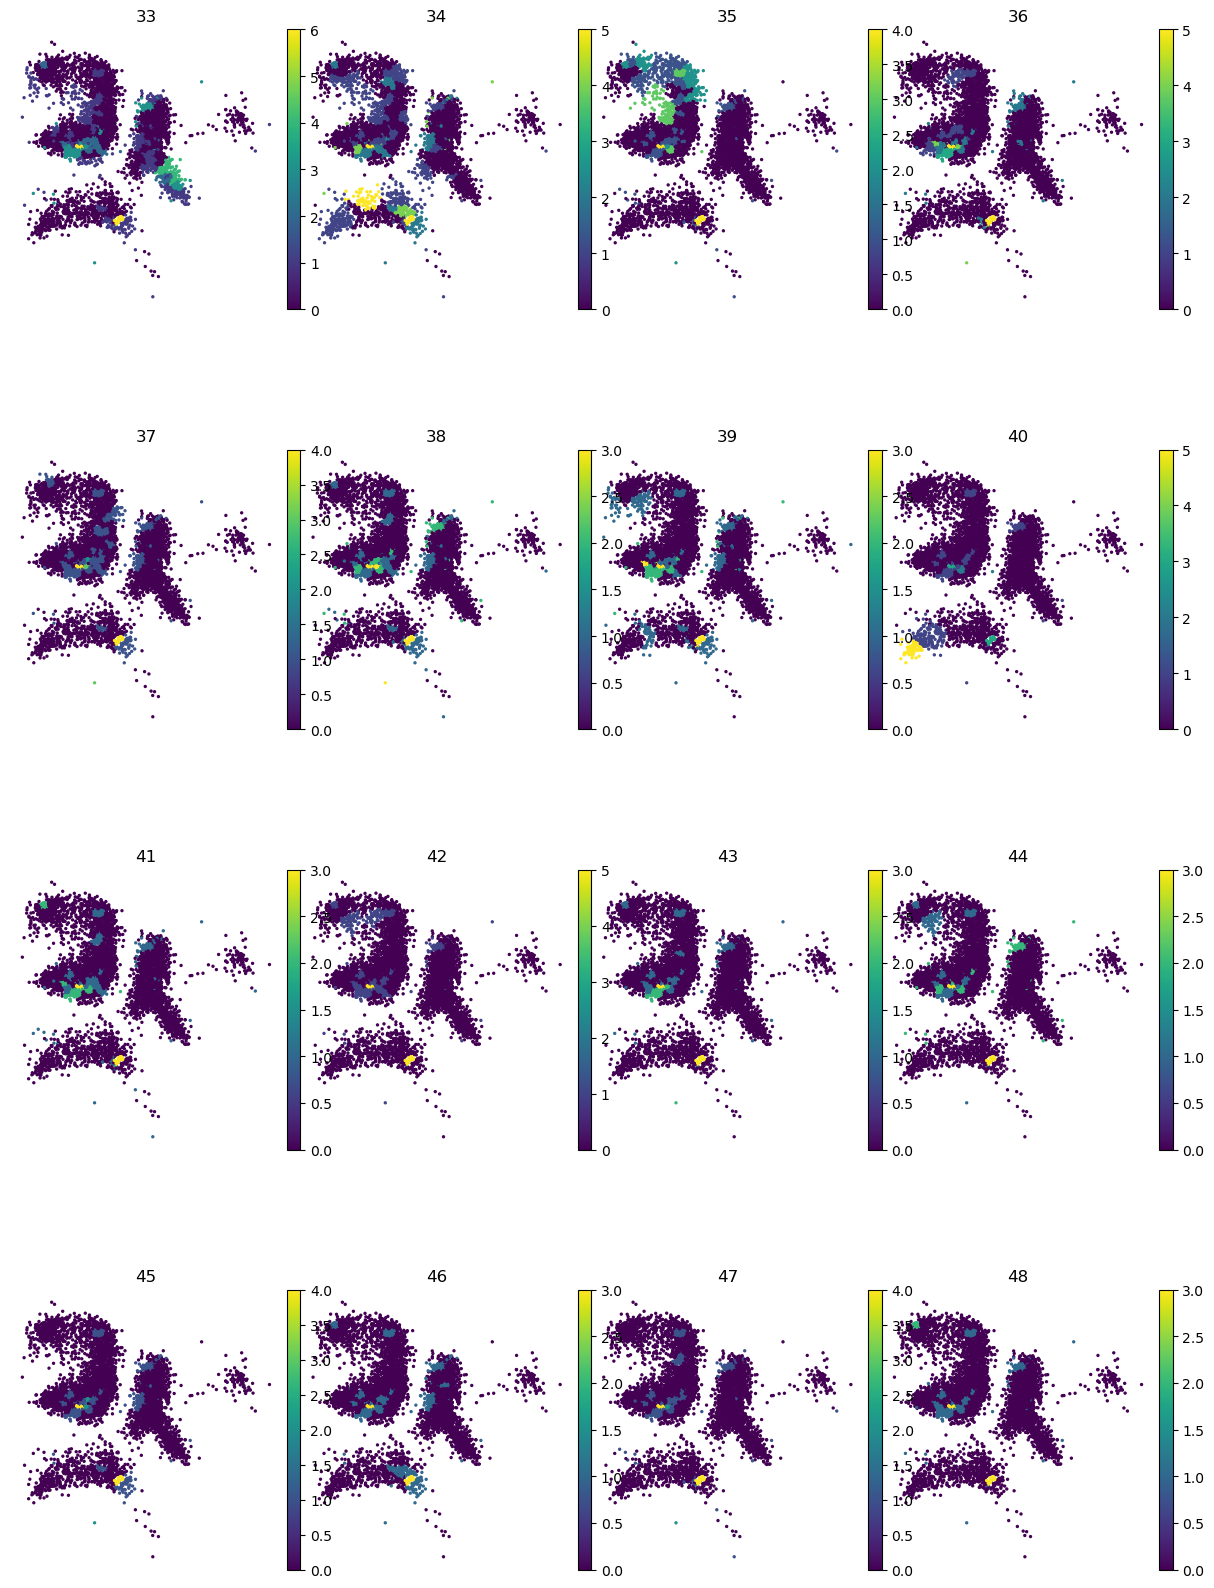

In [23]:
Global_Gene_Relevance_Map_PBMC10k(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=32)

#### Merged_Meta_Genes: We will merge some of the meta-genes that are very close together in the gene embedding and have similar meta-gene relevance maps. We aim to retain those meta-genes that cover all cells in the cell embedding.

In [25]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [26]:
[cells,embs1_num]=RNA_struct_MOGP.obsm['X_umap'].shape
metaGenes=rank_dhatMetagc.shape[1]
GR_g=np.zeros(metaGenes)
for g in range(metaGenes):
    nom=np.sum([rank_dhatMetagc[:,g]<=np.repeat(rg_max, cells)])
    s = nom/cells
    GR_g[g]=s  
idx = GR_g.argsort()[-metaGenes:][::-1]
rank_dhatMetagc=rank_dhatMetagc[:,idx]

In [27]:
mcs_genes_sorted0=mcs_genes[0].values[idx]
mcs_genes_sorted1=mcs_genes[1].values[idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[idx]

In [28]:
metaGenesList_new=[[0,1,2,3,4,5,7,11,12],[6],[8],[9,10,19],[24,29,17],[13,14,18,23],[16,20,22,26,27],[32],[21,30],[35],[36],[37]]

In [29]:
mcs_genes_sorted0_new=[]
mcs_genes_sorted1_new=[]
mcs_genes_sorted_SEACell_new=[]
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[0]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[1]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[2]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[3]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[4]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[5]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[6]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[7]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[8]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[9]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[10]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[11]]))

mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[0]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[1]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[2]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[3]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[4]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[5]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[6]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[7]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[8]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[9]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[10]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[11]]))

mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[0]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[1]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[2]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[3]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[4]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[5]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[6]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[7]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[8]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[9]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[10]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[11]])

In [30]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_MergedMetascore(RNA_struct_MOGP, Genes_struct_MOGP, metaGenesList_new, rank_dhatMetagc, rg_max)

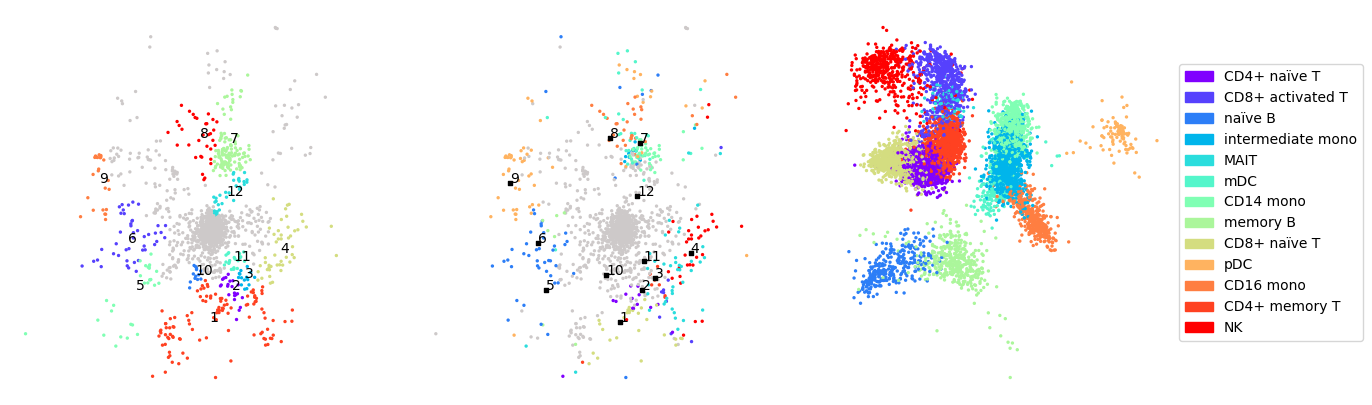

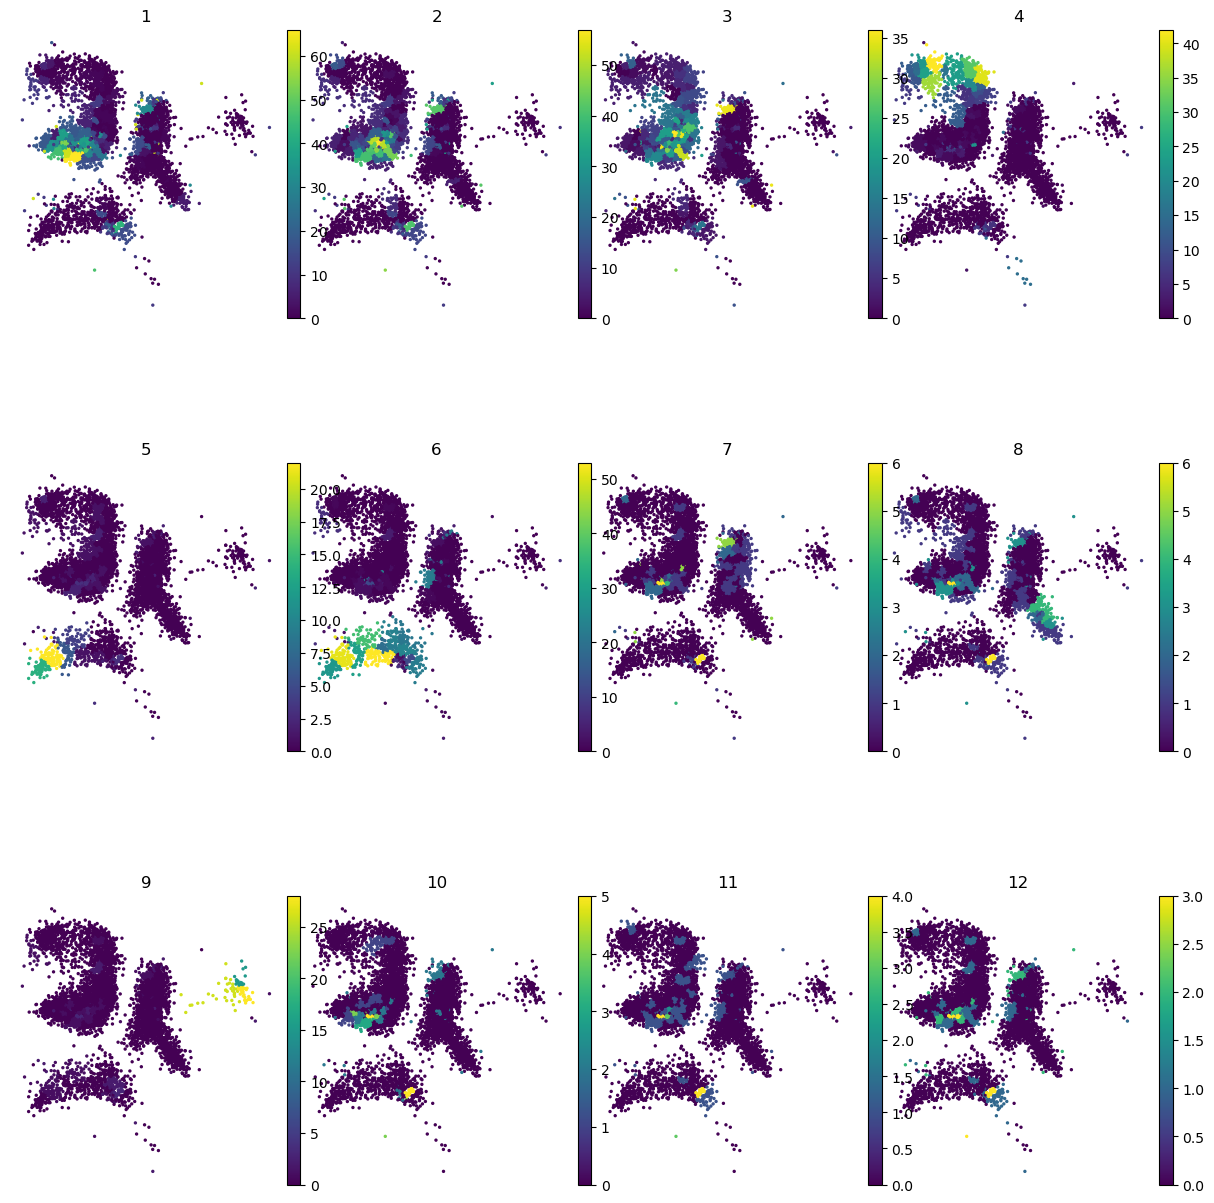

In [31]:
Global_Gene_Relevance_Map_PBMC10k(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0_new, mcs_genes_sorted1_new, mcs_genes_sorted_SEACell_new, LR_gPsi, avg_Psi, offset=0, topRG=12)

#### GEA: Over-representation analysis

In [32]:
gene_sets_all = os.path.join(data_folder_path,  "h.all.v2023.1.Hs.symbols.gmt")
gene_sets_CellType = os.path.join(data_folder_path,  "c8.all.v2023.1.Hs.symbols.gmt")
GEA(rna, RNA_struct_MOGP, Genes_struct_MOGP, mcs_genes_sorted_SEACell_new, gene_sets_all, gene_sets_CellType)

2024-06-04 12:04:59,628 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:04:59,651 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 1


2024-06-04 12:05:00,431 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:00,433 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:00,609 [INFO] Run: gs_ind_2 
2024-06-04 12:05:00,775 [INFO] Done.


Enrichment_CellType:


Gene_set                          Term Overlap       P-value  \
186  gs_ind_2  HAY_BONE_MARROW_NAIVE_T_CELL   44/61  4.895515e-46   
183  gs_ind_2    HAY_BONE_MARROW_CD8_T_CELL    4/15  7.145128e-03   

     Adjusted P-value  Odds Ratio  Combined Score  \
186      2.021848e-43   21.425619     2235.347581   
183      3.598705e-02    5.463843       26.998624   

                                                 Genes  
186  TC2N;CD96;NELL2;LINC01550;CCR7;SERINC5;LCK;ZEB...  
183                               SYNE2;CD8A;IL32;CD8B

2024-06-04 12:05:00,800 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:00,819 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 2


2024-06-04 12:05:01,629 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:01,632 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:01,718 [INFO] Run: gs_ind_2 
2024-06-04 12:05:01,801 [INFO] Done.


Enrichment_CellType:


Gene_set                          Term Overlap       P-value  \
71  gs_ind_2  HAY_BONE_MARROW_NAIVE_T_CELL   10/61  1.592135e-10   
72  gs_ind_2         HAY_BONE_MARROW_PRO_B     1/9  9.493571e-02   

    Adjusted P-value  Odds Ratio  Combined Score  \
71      2.738473e-08   26.490732      597.651434   
72      2.512145e-01   14.625459       34.436453   

                                                Genes  
71  TTC39C;TRBC1;SPOCK2;CAMK4;INPP4B;PCED1B;TSHZ2;...  
72                                              CMTM8

2024-06-04 12:05:01,818 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:01,837 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 3


2024-06-04 12:05:02,625 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:02,628 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:02,728 [INFO] Run: gs_ind_2 
2024-06-04 12:05:02,816 [INFO] Done.


Enrichment_CellType:


Gene_set                          Term Overlap   P-value  \
60  gs_ind_2    HAY_BONE_MARROW_CD8_T_CELL    1/15  0.107137   
62  gs_ind_2  HAY_BONE_MARROW_ERYTHROBLAST    1/23  0.159798   

    Adjusted P-value  Odds Ratio  Combined Score   Genes  
60          0.262514   13.251390       29.598868   ITGB1  
62          0.276004    8.705062       15.963716  TSPAN5

2024-06-04 12:05:02,835 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:02,856 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 4


2024-06-04 12:05:03,701 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:03,704 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:03,915 [INFO] Run: gs_ind_2 
2024-06-04 12:05:04,059 [INFO] Done.


Enrichment_CellType:


Gene_set                        Term Overlap       P-value  \
161  gs_ind_2    HAY_BONE_MARROW_NK_CELLS   39/69  2.495345e-54   
160  gs_ind_2  HAY_BONE_MARROW_CD8_T_CELL    4/15  3.286805e-04   

     Adjusted P-value  Odds Ratio  Combined Score  \
161      8.384358e-52  115.553578    14262.219818   
160      3.469507e-03   12.953606      103.893422   

                                                 Genes  
161  FCRL6;NCALD;NCR1;CST7;PYHIN1;LDB2;PTGDR;TRDC;S...  
160                              KLRG1;CCL5;TRGC2;GZMH

2024-06-04 12:05:04,084 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:04,105 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 5


2024-06-04 12:05:04,906 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:04,910 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:05,011 [INFO] Run: gs_ind_2 
2024-06-04 12:05:05,105 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap       P-value  \
107  gs_ind_2  HAY_BONE_MARROW_FOLLICULAR_B_CELL    8/37  1.476040e-08   
104  gs_ind_2       HAY_BONE_MARROW_CD34_POS_MKP     1/3  4.143518e-02   

     Adjusted P-value  Odds Ratio  Combined Score  \
107          0.000003   21.710244      391.464308   
104          0.171995   31.129870       99.105835   

                                                 Genes  
107  SLC38A11;LARGE1;TPD52;RRAS2;ABCB4;FCRL3;IKZF3;...  
104                                              GATA2

2024-06-04 12:05:05,124 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:05,143 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 6


2024-06-04 12:05:05,932 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:05,934 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:06,038 [INFO] Run: gs_ind_2 
2024-06-04 12:05:06,128 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap       P-value  \
90  gs_ind_2  HAY_BONE_MARROW_FOLLICULAR_B_CELL   20/37  5.863939e-26   
92  gs_ind_2        HAY_BONE_MARROW_PLASMA_CELL    5/23  1.024883e-04   

    Adjusted P-value  Odds Ratio  Combined Score  \
90      6.538292e-24   43.811429     2545.373499   
92      1.142744e-03   11.716940      107.629031   

                                                Genes  
90  CD79A;LINC02397;RALGPS2;BLK;ADAM28;OSBPL10;FCR...  
92                         FCRL5;IGLC3;IGHM;IGKC;IGHD

2024-06-04 12:05:06,145 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:06,164 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 7


2024-06-04 12:05:06,947 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:06,950 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:07,129 [INFO] Run: gs_ind_2 
2024-06-04 12:05:07,300 [INFO] Done.


Enrichment_CellType:


Gene_set                                 Term Overlap       P-value  \
222  gs_ind_2           HAY_BONE_MARROW_NEUTROPHIL   56/69  2.566710e-60   
220  gs_ind_2  HAY_BONE_MARROW_IMMATURE_NEUTROPHIL   21/25  1.427764e-22   

     Adjusted P-value  Odds Ratio  Combined Score  \
222      1.178120e-57   21.961010     3013.324692   
220      6.553435e-21   15.639602      786.683926   

                                                 Genes  
222  TET2;ACER3;CYBB;IRAK3;MEGF9;RAB11FIP1;ACSL1;GL...  
220  SLC8A1;BACH1;CTSS;NUMB;C9orf72;RIPK2;ATP2B1;AT...

2024-06-04 12:05:07,320 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:07,342 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 8


2024-06-04 12:05:08,135 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:08,137 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:08,275 [INFO] Run: gs_ind_2 
2024-06-04 12:05:08,418 [INFO] Done.


Enrichment_CellType:


Gene_set                                Term Overlap       P-value  \
140  gs_ind_2            HAY_BONE_MARROW_MONOCYTE   17/29  1.604491e-25   
138  gs_ind_2  HAY_BONE_MARROW_EARLY_ERYTHROBLAST     1/3  4.871170e-02   

     Adjusted P-value  Odds Ratio  Combined Score  \
140      4.989966e-23   70.880842     4046.716360   
138      1.202329e-01   26.340659       79.597152   

                                                 Genes  
140  C5AR1;TNFSF10;TCF7L2;CDKN1C;C1QA;HCK;TNFRSF1B;...  
138                                             CCDC26

2024-06-04 12:05:08,446 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:08,465 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 9


2024-06-04 12:05:09,267 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:09,272 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:09,415 [INFO] Run: gs_ind_2 
2024-06-04 12:05:09,530 [INFO] Done.


Enrichment_CellType:


Gene_set                            Term Overlap       P-value  \
88  gs_ind_2  HAY_BONE_MARROW_DENDRITIC_CELL   15/38  2.923487e-22   
86  gs_ind_2  HAY_BONE_MARROW_CD34_POS_PRE_B    3/20  1.334202e-03   

    Adjusted P-value  Odds Ratio  Combined Score  \
88      5.817738e-20   92.952636     4608.972326   
86      1.659414e-02   16.494349      109.183052   

                                                Genes  
88  WDFY4;LINC01374;PTPRS;CLEC4C;P2RY14;BCL11A;LIL...  
86                                 NIBAN3;RUBCNL;AFF3

2024-06-04 12:05:09,549 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:09,569 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 10


2024-06-04 12:05:10,346 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:10,349 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:10,411 [INFO] Run: gs_ind_2 
2024-06-04 12:05:10,468 [INFO] Done.
2024-06-04 12:05:10,477 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:10,497 [INFO] Input dict object named with gs_ind_2


Enrichment_CellType:
Top relenance Gene: 11


2024-06-04 12:05:11,274 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:11,275 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:11,394 [INFO] Run: gs_ind_2 
2024-06-04 12:05:11,474 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap   P-value  \
65  gs_ind_2  HAY_BONE_MARROW_CD34_POS_MULTILIN     1/1  0.010500   
68  gs_ind_2              HAY_BONE_MARROW_PRO_B     1/9  0.090801   

    Adjusted P-value  Odds Ratio  Combined Score  Genes  
65          0.255500   97.536585      444.413749   CDK6  
68          0.304974   15.338896       36.799332  RTKN2

2024-06-04 12:05:11,490 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:05:11,509 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 12


2024-06-04 12:05:12,294 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:05:12,297 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:05:12,462 [INFO] Run: gs_ind_2 
2024-06-04 12:05:12,576 [INFO] Done.


Enrichment_CellType:


Gene_set                                Term Overlap   P-value  \
130  gs_ind_2  HAY_BONE_MARROW_CD34_POS_ERP_EARLY     1/2  0.036667   
131  gs_ind_2       HAY_BONE_MARROW_CD34_POS_LMPP     1/3  0.054506   

     Adjusted P-value  Odds Ratio  Combined Score    Genes  
130          0.284033   32.852055      108.605038  ZNF385D  
131          0.304791   23.454012       68.238000    NEGR1

Meta Gene                                 Term Adjusted P-value  \
186          1         HAY_BONE_MARROW_NAIVE_T_CELL              0.0   
183          1           HAY_BONE_MARROW_CD8_T_CELL         0.035987   
71           2         HAY_BONE_MARROW_NAIVE_T_CELL              0.0   
72           2                HAY_BONE_MARROW_PRO_B         0.251214   
60           3           HAY_BONE_MARROW_CD8_T_CELL         0.262514   
62           3         HAY_BONE_MARROW_ERYTHROBLAST         0.276004   
161          4             HAY_BONE_MARROW_NK_CELLS              0.0   
160          4           HAY_BONE_MARROW_CD8_T_CELL          0.00347   
107          5    HAY_BONE_MARROW_FOLLICULAR_B_CELL         0.000003   
104          5         HAY_BONE_MARROW_CD34_POS_MKP         0.171995   
90           6    HAY_BONE_MARROW_FOLLICULAR_B_CELL              0.0   
92           6          HAY_BONE_MARROW_PLASMA_CELL         0.001143   
222          7           HAY_BONE_MARROW_NEUTROPHIL              0.0   
220          7  HAY_BONE_MARROW_IMMATURE_NEUTROPHIL              0.0   
140          8             HAY_BONE_MARROW_MONOCYTE              0.0   
138          8   HAY_BONE_MARROW_EARLY_ERYTHROBLAST         0.120233   
88           9       HAY_BONE_MARROW_DENDRITIC_CELL              0.0   
86           9       HAY_BONE_MARROW_CD34_POS_PRE_B         0.016594   
0           10                                  NaN              NaN   
1           10                                  NaN              NaN   
65          11    HAY_BONE_MARROW_CD34_POS_MULTILIN           0.2555   
68          11                HAY_BONE_MARROW_PRO_B         0.304974   
130         12   HAY_BONE_MARROW_CD34_POS_ERP_EARLY         0.284033   
131         12        HAY_BONE_MARROW_CD34_POS_LMPP         0.304791   

    Combined Score  
186    2235.347581  
183      26.998624  
71      597.651434  
72       34.436453  
60       29.598868  
62       15.963716  
161   14262.219818  
160     103.893422  
107     391.464308  
104      99.105835  
90     2545.373499  
92      107.629031  
222    3013.324692  
220     786.683926  
140     4046.71636  
138      79.597152  
88     4608.972326  
86      109.183052  
0              NaN  
1              NaN  
65      444.413749  
68       36.799332  
130     108.605038  
131         68.238